---
# <center> **An Introduction to Data Science**
## <center> Spring 2024

### <center> **Prof. Bahram Mobasher**
### Teaching Assistant: **Sina Taamoli** | email: *sina.taamoli@email.ucr.edu*
### [Course webpage](https://github.com/sinataamoli/Applied-Data-Science)
#### Week 8 (April 25th): MCMC
---

## Marcov Chain Monte Carlo (MCMC) <br>
In simple Bayesian problems with a small number of parameters, it is possible to compute the exact form of the posterior distribution, but in the real problems due to a large number of parameters, calculations get complicated. MCMC is the class of algorithms for sampling from a probability distribution (e.g. posterior). In other words, we want to sample the probability distribution such that the chance of sampling each point is proportional to the true distribution.

Let's look into a very simple example. Imagine that the weather condition (Sunny(S) or Rainy(R)) of day n only depends on the weather condition of day n-1.
And also the following conditional probabilities are given:

$P(S_{n+1} | S_{n}) = 90\%$ <br>
$P(R_{n+1} | S_{n}) = 10\%$ <br>
$P(S_{n+1} | R_{n}) = 50\%$ <br>
$P(R_{n+1} | R_{n}) = 50\%$ 

We want to find the probability of sunny and rainy weather. If you remember the linear algebra part of the course and our example in session 2, given the initial state of the system [S R] (for example [1 0] for sunny day) then the prediction for next day is:

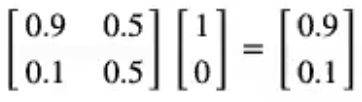

And the final state regardless of initial condition converges to the eigenvector (X) of transition matrix:

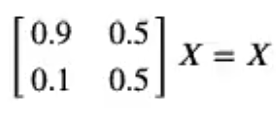

Finding eigenvector we know that the probability of sunny weather regardless of the initial condition is 83.3% and rainy weather is 16.6%.

In [5]:
import numpy as np

T = np.array([[0.9, 0.5], [0.1, 0.5]])
Eigenvector = np.linalg.eig(T)[1][:, 0]
Eigenvector

array([0.98058068, 0.19611614])

In [6]:
Eigenvector / np.sum(Eigenvector)

array([0.83333333, 0.16666667])

Use MCMC to solve the problem. Consider an initial weather condition. For example Sunny (S), then generate a random uniform number between 0 and 1, if the number less than 0.9, stay at the same state "S", otherwise jump to "R*. If you are on "R" state, if the number is less than 0.5, stay at "R", otherwise jump to "S". Repeat the procedure for a large number of times and then the fraction of "R" shows the probability of rainy and the fraction of "S" shows the probability of sunny weather.

In [7]:
def State(state_i):

    rand = np.random.rand()
    if state_i == "S":
        if rand > 0.9:
            State_f = "R"
        else:
            State_f = "S"

    if state_i == "R":
        if rand > 0.5:
            State_f = "S"
        else:
            State_f = "R"

    return State_f

In [54]:
Outcome = ["S"]
for N in range(100000):
    Outcome.append(State(Outcome[-1]))

In [55]:
Outcome[-10:]

['R', 'R', 'S', 'S', 'S', 'S', 'R', 'R', 'R', 'S']

In [56]:
PS = Outcome.count("S") / len(Outcome)
PS

0.8354016459835402

In [57]:
PR = Outcome.count("R") / len(Outcome)
PR

0.16459835401645984

1) Initialize all the variables ($theta$) and number of itrations n

### for n iterations

2) Find the posterior at point $\theta$

3) Define a reasonable function to move from $\theta$ to $\theta'$

4) Find $r = \frac{\text{Posterior} (\theta')}{\text{Posterior} (\theta)}$

5) Generate a uniform random number(rand) between 0, 1

6) if r>rand, then move to new point $\theta'$, otherwise, stay in the same point

In [72]:
def MCMC(log_Posterior, data, initial, step_cov, n_iteration):
    
    param1 = np.array(initial)
    sample = np.array(initial)
    
    for j in range (n_iteration):
        log_Posterior_i = log_Posterior(data, param1)
        # Update the location 
        param2 = np.random.multivariate_normal(param1, step_cov)
        # find the new posterior
        log_Posterior_f = log_Posterior(data, param2)
        # Generate a random number between 0, 1
        rand = np.random.rand()
        
        if log_Posterior_f-log_Posterior_i > np.log(rand):
            sample = np.vstack((sample, param2))
            param1 = param2[:]
            
        else:
            sample = np.vstack((sample, param1))
            
    return sample

In [61]:
import pandas as pd

data = pd.read_csv('tweet_counts.csv')

In [62]:
data.head()

,week,count
0,1,39.0
1,2,46.0
2,3,41.0
3,4,42.0
4,5,31.0


In [63]:
k = data['count'].values
w = data['week'].values

In [64]:
alpha = 1 / np.mean(k)

In [65]:
Poisson = lambda k, lamb: (lamb**k) / np.math.factorial(k) * np.exp(-lamb)

In [73]:
def log_posterior(data, param):
    k, w = data
    lamb1, lamb2, W_s = param
    
    P = 0
    
    for i in k[w < W_s]:
        P = P + np.log(Poisson(i, lamb1) * α * np.exp(-α * lamb1))
        
    for j in k[w > W_s]:
        P = P + np.log(Poisson(i, lamb2) * α * np.exp(-α * lamb2))
        
    return P

In [70]:
len(w)

52

In [74]:
D = MCMC(log_Posterior, data = [k, w], initial = [20, 25, 30], step_cov = [[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.5]], n_iteration = 30000)